# 数値流体ゼミ第五回
# 第3章　スカラー移流方程式における時間積分法  
<br />
<center>川村岳
<center>2021年5月26日

## 3.4 内部反復を利用した時間精度の向上

***
前回やったこと（復習）：<br>
時間積分の方法には**陽解法**と**陰解法**の二通りがある。
#### 陽解法
<center>$q^{n+1}_j = $(時刻nでの値)</center>

#### 陰解法
<center>$q^{n+1}_j = $(時刻nとn+1での値)</center>

- 陽解法の方が計算は楽だが，クーラン数$\nu=c\dfrac{\Delta t}{\Delta x}<1.0$という制限がある
- 陰解法は，計算量を引き換えに時間に対する安定性を得ている
***

（補足？）一般の（デルタ形式の）陰解法

\begin{equation}
B(-\nu,1+\nu,0)\Delta q^n_j=-\Delta t \cdot R^n(q_j)
\end{equation}

について，左辺は時間に関するオペレータ，右辺は時間$n$ステップにおいて$j$の位置で評価した空間微分項である．右辺には一般にTVD法（→2.8節）など2次精度以上の離散化手法が適用され，一方で左辺の演算に1次精度を利用して問題ない．

***
### 問題
時間陰解法で大きな時間刻み幅をとったとき，計算自体は安定に進んでも，時間項から生まれ，蓄積する誤差が無視できないものになってしまう．
### 目標
大きな時間ステップを利用する場合に，十分な時間精度を維持するための工夫を学ぼう！
***

\begin{equation}
\Bigl( 1+\Delta\cdot\dfrac{\partial}{\partial x}\Bigl(\dfrac{\partial f}{\partial q}\Bigr) \Bigr)^n_j \Delta q^n_j = -\Delta t \cdot \left. \dfrac{\partial f}{\partial x}\right|_{j}^n
\ \ (=\Delta t\cdot R^n(q_j))
\end{equation}

通常は左辺の計算を一回だけ行うが，今回**内部反復**を導入し，時間1ステップの計算を反復して行う．

もともとオイラー陰解法の一般的な形は

\begin{align}
\Delta q^n_j &= -\Delta t \cdot \Bigl(\dfrac{\partial f}{\partial x}\Bigr)^{(n+1)}_j \\
&= -\Delta t \cdot \dfrac{\partial}{\partial x}\Big[f^n_j+\left.\dfrac{\partial f}{\partial q}\right|^n_j(\Delta q^n) + O\bigl((\Delta q^n_j)^2\bigr) \Bigr]
\end{align}

内部反復の回数を$m$として$\lim_{m \to \infty}q^{(m)}_j=q^{(n+1)}_j$となるような$q^{(m)}_j$を定義し，$q^{(m+1)}_j = q^{(m)}_j+\Delta q^{(m+1)}_j$とすると，内部反復の計算は

\begin{equation}
q^{(m+1)}_j - q^n_j = \Delta q^{(m)}_j + q^{(m)}_j - q^n_j = \Delta t \cdot \left. \dfrac{\partial f}{\partial x} \right|^{(m)}_j
\ \ (=\Delta t\cdot R^{(m)}(q_j))
\end{equation}

となる．（教科書と$m$が1ずれていることに注意）mに関する内部反復を$\Delta q^{(m)}_j$が0になるまで繰り返すと，結果は

\begin{equation}
q^{(m)}_j-q^n_j=\Delta t \cdot \left. \dfrac{\partial f}{\partial x}\right|_{j}^{(m)}
\end{equation}

を満たす．すなわち，大きな$\Delta t$を用いても各時間ステップの結果が

\begin{equation}
\dfrac{\partial q}{\partial t} + \dfrac{\partial f}{\partial x}=0
\end{equation}

を時間1次精度で満たすことになる．こうして得られた$q^{(m)}_j$を$q^{(n+1)}_j$として，次の時間ステップの計算に移ることになる．

この考え方を式(3.26)（p.100）に適用すると

\begin{equation}
\Bigl(1+\Delta t\cdot \dfrac{\partial c^{+}}{\partial x}+\Delta t\cdot\dfrac{\partial c^{-}}{\partial x}\Bigr)^{(m)}_j\Delta q^{(m+1)}_j=-\bigl(q^{(m)}_j-q^n_j\bigr)-\Delta t\cdot R^{(m)}(q_j)
\end{equation}

となる．近似LDU分解などを用いてこの計算を$\Delta q^{(m+1)}_j=0$となるまで繰り返せばよい．
実際は0に収束するまで計算する必要はなく，数回〜数十回で十分であることが経験的に知られている．

In [154]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def init(q1, q2, xs, dx, jmax):
    xs = -1 # 始点
    x = np.linspace(xs, xs + dx * (jmax-1), jmax)
    q = np.array([(float(q1) if i < 0.0 else float(q2)) for i in x])
    return (x, q)

def UPWIND1(alf, q, c, dt, dx, jmax):
    for j in range(0, jmax-1):
        ur, ul = q[j+1], q[j]
        fr, fl = c * ur, c * ul
        alf[j] = 0.5 * (fr + fl - abs(c) * (ur - ul))
        
def do_computing_LDU(x, q, c, dt, dx, nmax, ff, interval=2, xlim=None):
    plt.figure(figsize=(5,5), dpi=100)
    plt.rcParams["font.size"] = 15
    
    plt.plot(x, q, marker='o', lw=2, label='t = 0')
    
    alf = np.zeros(jmax)
    dq = np.zeros(jmax)
    for n in range(1, nmax+1):
        qold = q.copy()
        qm = q.copy() #new
        
        #近似LDU分解
        c_a = abs(c)
        c_p = 0.5 * (c + c_a)
        c_n = 0.5 * (c - c_a)
        nu_a = c_a * dt / dx
        nu_p = c_p * dt / dx
        nu_n = c_n * dt / dx
        
        #内部反復
        for k in range(50):
            
            ff(alf, qm, c, dt, dx, jmax)
            R = np.append(0.0, np.diff(alf) / dx)
            
            ##第1スイープ
            for j in range(1, jmax-1):
                dq[j] = (-(qm[j]-qold[j]) -dt * R[j] + nu_p * dq[j-1]) / (1 + nu_a)
        
            ##第2，第3スイープ
            for j in range(jmax-2, 0, -1):
                dq[j] = dq[j] - nu_n * dq[j+1] / (1 + nu_a)
        
            #q^(m+1)
            for j in range(1, jmax-1):
                qm[j] = qm[j] + dq[j]
            
        #qmが収束したとしてq^(n+1)とする
        for j in range(1,jmax-1):
            q[j] = qm[j]
            
        #自由端にする
        q[-1] = q[-2] 
            
        #各ステップの可視化
        if n % interval == 0:
            plt.plot(x, q, marker='o',markersize=5, lw=2, label=f't = {dt * n : .1f}')
            
    plt.grid(color='black', linestyle='dashed', linewidth=0.2)
    plt.xlabel('x')
    plt.ylabel('q')
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()
    plt.show()

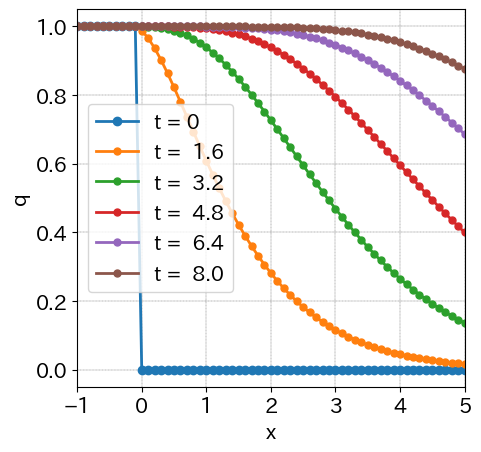

In [155]:
c = 1
dt = 0.8
dx = 0.1

jmax = 70
nmax = 10

xs = -1

q1 = 1
q2 = 0
x, q = init(q1, q2, xs, dx, jmax)
do_computing_LDU(x, q, c, dt, dx, nmax, UPWIND1, interval=2, xlim=[-1,5])

$dt=0.08$での結果が鈍ったままだが，時間1次精度&差分法なので仕方ない？

[参考にしたブログ記事](https://teru-hide.com/cfd-inner-iteration/)

#### 時間2次精度を満たす手法
以下のように修正することで，時間2次精度を満たすことができる（らしい）．

\begin{equation}
\Bigl(1+\dfrac{2}{3}\Delta t\cdot\dfrac{\partial c^+}{\partial x}+\dfrac{2}{3}\Delta t\cdot\dfrac{\partial c^-}{\partial x}\Big)^{(m-1)}_j\Delta q^{(m)}_j=-\dfrac{2}{3}\Delta t\dfrac{3q^{(m-1)}_j-4q^n_j+q^{n-1}_j}{2\Delta t}-\Delta t\cdot R^{(m-1)}(q_j)
\end{equation}

In [152]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def init(q1, q2, xs, dx, jmax):
    xs = -1 # 始点
    x = np.linspace(xs, xs + dx * (jmax-1), jmax)
    q = np.array([(float(q1) if i < 0.0 else float(q2)) for i in x])
    return (x, q)

def UPWIND1(alf, q, c, dt, dx, jmax):
    for j in range(0, jmax-1):
        ur, ul = q[j+1], q[j]
        fr, fl = c * ur, c * ul
        alf[j] = 0.5 * (fr + fl - abs(c) * (ur - ul))
        
def do_computing_LDU(x, q, c, dt, dx, nmax, ff, interval=2, xlim=None):
    plt.figure(figsize=(5,5), dpi=100)
    plt.rcParams["font.size"] = 15
    
    plt.plot(x, q, marker='o', lw=2, label='t = 0')
    
    alf = np.zeros(jmax)
    dq = np.zeros(jmax)
    qold = q.copy()
    for n in range(1, nmax+1):
        qoldold = qold.copy()
        qold = q.copy()
        qm = q.copy() #new
        
        #近似LDU分解
        c_a = abs(c)
        c_p = 0.5 * (c + c_a)
        c_n = 0.5 * (c - c_a)
        nu_a = c_a * dt / dx
        nu_p = c_p * dt / dx
        nu_n = c_n * dt / dx
        
        #内部反復
        for k in range(50):
            
            ff(alf, qm, c, dt, dx, jmax)
            R = np.append(0.0, np.diff(alf) / dx)
            
            ##第1スイープ
            for j in range(1, jmax-1):
                dq[j] = (-(3*qm[j]-4*qold[j]+qoldold[j])/3 -dt * R[j] + 2/3 * nu_p * dq[j-1]) / (1 + 2/3 * nu_a)
        
            ##第2，第3スイープ
            for j in range(jmax-2, 0, -1):
                dq[j] = dq[j] - 2/3 * nu_n * dq[j+1] / (1 + 2/3 * nu_a)
        
            #q^(m+1)
            for j in range(1, jmax-1):
                qm[j] = qm[j] + dq[j]
            
        #qmが収束したとしてq^(n+1)とする
        for j in range(1,jmax-1):
            q[j] = qm[j]
            
        #自由端にする
        q[-1] = q[-2] 
            
        #各ステップの可視化
        if n % interval == 0:
            plt.plot(x, q, marker='o',markersize=5, lw=2, label=f't = {dt * n : .1f}')
            
    plt.grid(color='black', linestyle='dashed', linewidth=0.2)
    plt.xlabel('x')
    plt.ylabel('q')
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()
    plt.show()

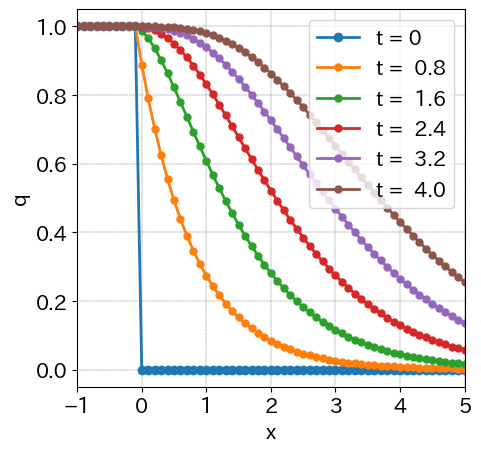

In [156]:
c = 1
dt = 0.8
dx = 0.1

jmax = 70
nmax = 5

xs = -1

q1 = 1
q2 = 0
x, q = init(q1, q2, xs, dx, jmax)
do_computing_LDU(x, q, c, dt, dx, nmax, UPWIND1, interval=1, xlim=[-1,5])

## 3.5 多次元問題への拡張

2次元のスカラー定数係数の移流方程式（式（2.55）再掲）

\begin{equation}
\dfrac{\partial q}{\partial t}+c\dfrac{\partial q}{\partial x}+d\dfrac{\partial q}{\partial y}=0
\end{equation}

デルタ形式のオイラー陰解法を適用する．

\begin{equation}
\Bigl(1+\Delta t\cdot \dfrac{\partial}{\partial x}c+\Delta t\cdot\dfrac{\partial}{\partial y}d\Bigr)^n_{j,k}\Delta q^n_{j,k}=-\Delta t\cdot R^n(q_{j,k})
\end{equation}

$c=\dfrac{\partial f}{\partial q}$，$d=\dfrac{\partial g}{\partial q}$が，それぞれの方向の**流束ヤコビアン**である．
<br>
（スカラー移流方程式なので簡単に書けているが，一般には$c_{k,l}=\dfrac{\partial f_k}{\partial q_l}$みたいな感じ．）

未知ベクトル$\ \bigl(\Delta q^n_{j,k}$や$q^{n+1}_{j,k}\bigr)\ $のサイズ→左辺の係数行列のサイズ
- 1次元：$j_{max}\rightarrow j_{max}^2$                               
例：$100\rightarrow100\times100$
- 2次元：$j_{max}\times k_{max}\rightarrow (j_{max}\times k_{max})^2$                 
例：$10^4\rightarrow10^4\times10^4$
- 3次元：$j_{max}\times k_{max}\times l_{max}\rightarrow(j_{max}\times k_{max}\times l_{max})^2$   
例：$10^6\rightarrow10^6\times10^6$

行列反転（=連立1次方程式を解くこと）は難しくないものの，次元を増やすほど非現実的なデータ数になってしまう．
<br>
→適切な近似手法を用いて（1次元のときのように）行列反転せずに解く

### 手法(1) ADI：方向別のAF法
式(11)に以下のような近似因数分解を施す．

\begin{equation}
\Bigl(1+\Delta t\cdot\dfrac{\partial}{\partial x}c\Bigr)\Bigl(1+\Delta t\cdot\dfrac{\partial}{\partial y}d\Bigr)^n_{j,k}\Delta q^n_{j,k}=-\Delta t\cdot R^n(q_j)
\end{equation}

無視した誤差項は$\ (\Delta t)^3\ $のオーダなので，時間2次精度が確保されている．
空間微分に1次精度風上を利用した場合は以下のようになる．

\begin{equation}
(1+\Delta t\cdot \delta^b_xc^++\Delta t\cdot\delta^f_xc^-)(1+\Delta t\cdot\delta^b_yd^++\Delta t\cdot\delta^f_yd^-)^n_{j,k}\Delta q^n_{j,k}
\end{equation}

あとは前節にやったことと同じ

**[第一スイープ]**
\begin{equation}
(1+\Delta t\cdot\delta^b_xc^++\Delta t\cdot\delta^f_xc^-)^n_{j,k}\Delta q^*_{j,k}=-\Delta t\cdot R^n(q_{j,k})
\end{equation}

**[第二スイープ]**
\begin{equation}
(1+\Delta t\cdot\delta^b_yd^++\Delta t\cdot\delta^f_yd^-)^n_{j,k}=\Delta q^*_{j,k}
\end{equation}

2式ともそれぞれ一次元の演算になっており，これらのループを前節の方法に従ってさらに二つずつのループに分けることで，行列反転せず答えが求まる．

### 手法(2) 多次元での近似LU分解法
式(11)に今度は別の方法で近似因数分解を施す．

\begin{equation}
\Bigl(1+\Delta t\cdot\dfrac{\partial}{\partial x}c^++\Delta t\cdot\dfrac{\partial}{\partial y}d^+\Bigr)\Bigl(1+\Delta t\cdot\dfrac{\partial}{\partial x}c^-+\Delta t\cdot\dfrac{\partial}{\partial y}d^-\Bigr)^n_{j,k}\Delta q^n_{j,k}=-\Delta t\cdot R^n(q_{j,k})
\end{equation}

(13)式と同様に書き換えると

\begin{equation}
(1+\Delta t\cdot \delta^b_xc^++\Delta t\cdot\delta^b_yd^+)(1+\Delta t\cdot\delta^f_xc^-+\Delta t\cdot\delta^f_yd^-)^n_{j,k}\Delta q^n_{j,k}=-\Delta t\cdot R^n(q_{j,k})
\end{equation}

**[第一スイープ]**
\begin{equation}
(1+\Delta t\cdot\delta^b_xc^++\Delta t\cdot\delta^b_yd^+)^n_{j,k}\Delta q^*_{j,k}=-\Delta t\cdot R^n(q_{j,k})
\end{equation}

**[第二スイープ]**
\begin{equation}
(1+\Delta t\cdot\delta^f_xc^-+\Delta t\cdot\delta^f_yd^-)^n_{j,k}=\Delta q^*_{j,k}
\end{equation}

多次元問題に対しても**近似LU分解**が有効であることがわかる．もちろん近似LDU分解を用いてより精度を高めることも可能．ただし，今回のようなhyperplaneを利用する手法はループ長が変動するため，最近のコンピュータ的には少々非効率であり，工夫が必要．なお，今回示した近似LU分解は楕円型方程式（→第4章）などでよく用いられるSGS法の1回分のループと同じ（らしい）．そのため**LU-SGS法**と呼ばれることもある．